In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from WeightedBinaryCrossentropy import WeightedBinaryCrossentropy

In [2]:
data = pd.read_csv(r'..\Data\multivariate_timeseries_data_mangalore_extreme.csv')
data.drop(columns=['location'], inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp')
X = data.loc[:,'temperature':'precipitation']
y = data.loc[:,'power_outage']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,shuffle=False,random_state=0)
X_train.reset_index(inplace=True, drop = True)
X_test.reset_index(inplace= True, drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      14400 non-null  datetime64[ns]
 1   temperature    14400 non-null  float64       
 2   humidity       14400 non-null  float64       
 3   wind_speed     14400 non-null  float64       
 4   precipitation  14400 non-null  float64       
 5   power_outage   14400 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 675.1 KB


In [3]:
def prepro(X):    
    scaler = MinMaxScaler()
    scaler.fit(X_train.loc[:,'temperature':])
    X_scaled = scaler.transform(X.loc[:,'temperature':])
    X_t = pd.DataFrame(X_scaled)
    return X_t.to_numpy()

In [4]:
X_te = prepro(X_test)
X_tr = prepro(X_train)

In [5]:
# now X_tr and X_te are lists to be put into timeseries gen
l = 16
batch = 30
gen_train = tfk.preprocessing.sequence.TimeseriesGenerator(np.asarray(X_tr), np.asarray(y_train), length = l, sampling_rate = 1, batch_size = batch, stride = 1)
gen_test = tfk.preprocessing.sequence.TimeseriesGenerator(np.asarray(X_te), np.asarray(y_test), length = l, sampling_rate = 1, batch_size = batch, stride = 1)
gen_test

In [6]:
model = tfk.Sequential()
model.add(tfk.Input(shape = (16,4)))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(128, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.4))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(64, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.4))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(64, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.4))
model.add(tfk.layers.LSTM(128, return_sequences=False))
model.add(tfk.layers.Dropout(0.3))
model.add(tfk.layers.Dense(1))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16, 256)          136192    
 l)                                                              
                                                                 
 re_lu (ReLU)                (None, 16, 256)           0         
                                                                 
 dropout (Dropout)           (None, 16, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 128)          164352    
 nal)                                                            
                                                                 
 re_lu_1 (ReLU)              (None, 16, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0

In [8]:
early_stop = tfk.callbacks.EarlyStopping(monitor = 'loss',patience=2,mode='min')
model.compile(loss = WeightedBinaryCrossentropy(weights = [1,4]), optimizer= tfk.optimizers.Adam(), metrics=['accuracy'])

In [9]:
1 - data['power_outage'].mean()

0.7916666666666666

In [10]:
history = model.fit(gen_train,epochs=15,shuffle=False, callbacks= [early_stop])

Epoch 1/15
456/456 [==============================] - 33s 41ms/step - loss: 0.9016 - accuracy: 0.8635
Epoch 2/15
456/456 [==============================] - 19s 43ms/step - loss: 0.4206 - accuracy: 0.9481
Epoch 3/15
456/456 [==============================] - 19s 42ms/step - loss: 0.2833 - accuracy: 0.9641
Epoch 4/15
456/456 [==============================] - 19s 42ms/step - loss: 0.5574 - accuracy: 0.9558
Epoch 5/15
456/456 [==============================] - 19s 42ms/step - loss: 1.1448 - accuracy: 0.8628


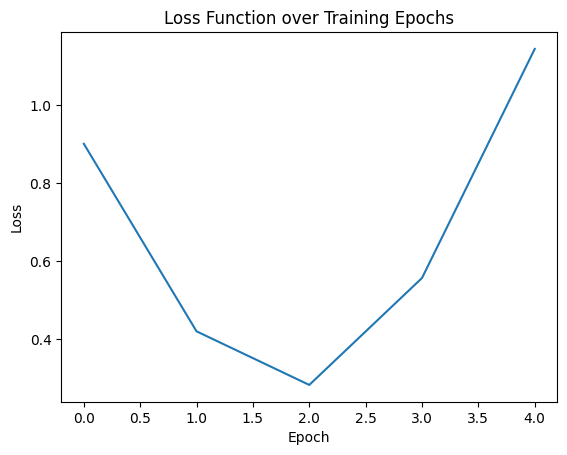

In [11]:
loss_values = history.history['loss']

# Plot the loss function graph
plt.plot(loss_values)
plt.title('Loss Function over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
model.evaluate(gen_test)

24/24 [==============================] - 0s 12ms/step - loss: 0.1703 - accuracy: 0.9716


[0.1702563762664795, 0.9715909361839294]

In [13]:
def plot_roc_curve(y_test, y_prob):

    fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

24/24 [==============================] - 3s 12ms/step


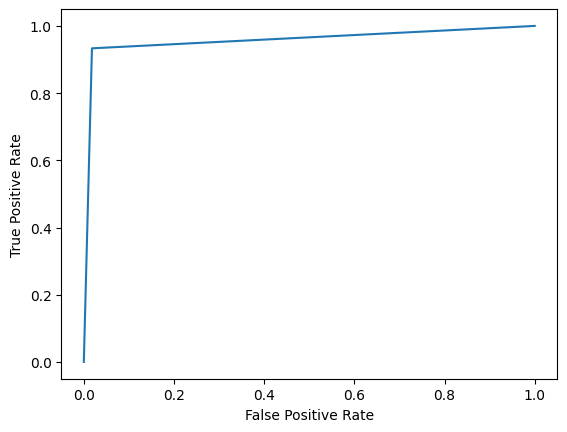

In [14]:
yhat = model.predict(gen_test)
yhat = [1 if x>0.5  else 0 for x in yhat]
plot_roc_curve(y_test[l:],yhat)

F1 measure: 0.9333333333333333
ROC AUC: 0.9576413959085439


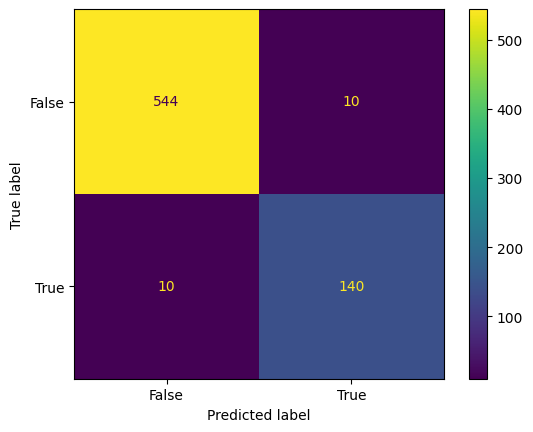

In [15]:
confusion_matrix_test = metrics.confusion_matrix(y_test[l:],yhat)
cmt = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
print(f'F1 measure: {metrics.f1_score(y_test[l:],yhat)}\nROC AUC: {metrics.roc_auc_score(y_test[l:],yhat)}')
cmt.plot()
plt.show()

0.7869318181818181


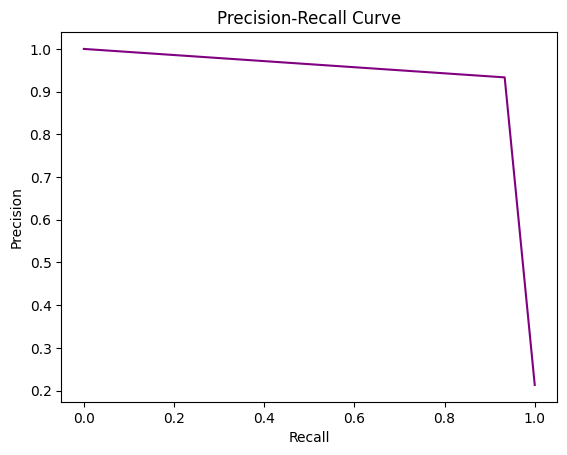

In [16]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test[l:], yhat)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
print(ax.get_data_ratio())

#display plot
plt.show()

In [18]:
# model.save_weights(r'..\Pretrained Weights\po_model')

In [11]:
model.load_weights(r'..\Pretrained Weights\po_model')

In [17]:
model.evaluate(gen_train)

456/456 [==============================] - 6s 12ms/step - loss: 0.1621 - accuracy: 0.9731


[0.16209304332733154, 0.9730679392814636]